# Environment Set Up

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
from smurfs_dataset import SmurfsDataset
import ipywidgets as widgets
from IPython.display import display

import torch
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import torchvision.transforms as transforms
import torch

from tensorboardX import SummaryWriter 

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2 
import urllib.request
import random

from pycocotools.coco import COCO

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
import segmentation_models_pytorch.utils.losses as loss_lib

# Loading and Labeling Data

In [18]:
data_path = "/data/smurfs_coco_format/"
json_file_name = "result.json"

num_images = 42
imgs_ids = list(range(num_images))
dataset = SmurfsDataset(data_path, json_file_name, imgs_ids)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [19]:
def update_annot_cat(dataset):
    print("Category Ids:", dataset.categ_dict)
    
    while True:
        ann_id = input("Enter Annotation Id: ")
    
        if not ann_id.isdigit():
            break
            
        cat_id = input("Enter Category Id: ")
    
        if not cat_id.isdigit():
            break
        
        dataset.set_annot_cat_by_id(int(cat_id), int(ann_id))
        dataset.update_json_cat_by_ann_id(int(cat_id), int(ann_id))
        print(f'Annotation ID {ann_id} with new category id {cat_id}')
    
        print("-------------")

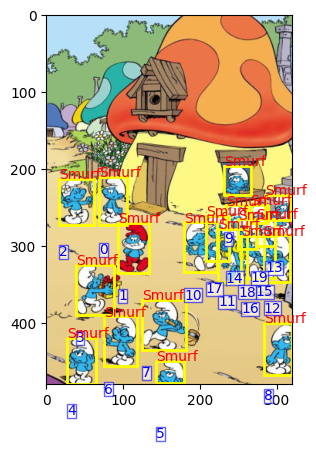

In [20]:
dataset.visualize_annot_by_imgid(0)

In [21]:
if False:
    update_annot_cat(dataset)

# Preprocessing Data

## Train - Test Split

In [74]:
data_path = "/data/smurfs_coco_format/"
json_file_name = "updated_result.json"

num_images = 42
imgs_ids = list(range(num_images))

train_images = int(num_images*0.75)
test_images = num_images - train_images

train_ids = random.sample(imgs_ids,train_images)
test_ids = list(set(imgs_ids) - set(train_ids))


train_dataset = SmurfsDataset(data_path, json_file_name, train_ids)
test_dataset = SmurfsDataset(data_path, json_file_name, test_ids)

print("Categories: ", train_dataset.categ_dict)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Categories:  {0: {'id': 0, 'name': 'Smurf'}, 1: {'id': 1, 'name': 'Papa Smurf'}, 2: {'id': 2, 'name': 'Smurfette'}, 3: {'id': 3, 'name': 'Vanity Smurf'}}


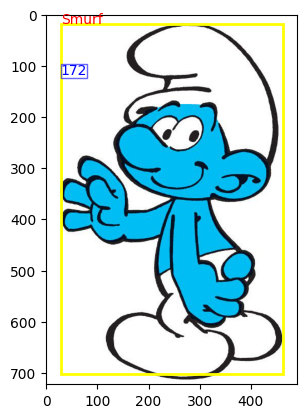

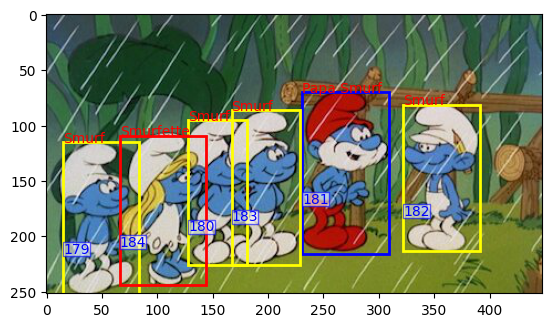

In [75]:
train_dataset.visualize_annot_by_imgid(28)
test_dataset.visualize_annot_by_imgid(10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


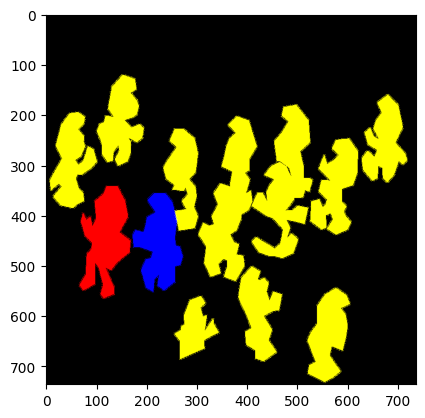

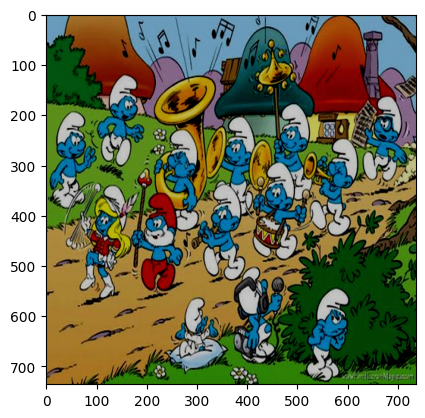

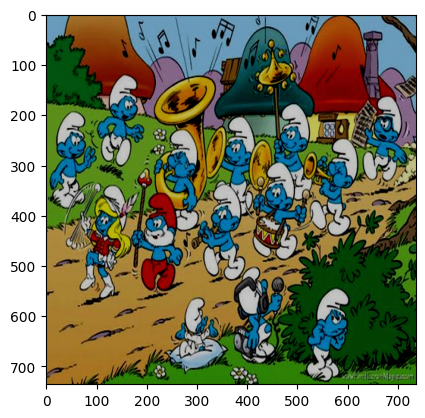

In [76]:
data = train_dataset.__getitem__(0)

mask = data['target']['segmentation'].detach().numpy()

toPIL_transform = transforms.ToPILImage()
img_tensor = data['image'].detach()
img_pil = toPIL_transform(img_tensor)

img = toPIL_transform(data['image_pil'])
# print(img.shape)
rgb_mask = train_dataset.generate_multi_class_mask(mask)

plt.figure()
plt.imshow(rgb_mask)

plt.figure()
plt.imshow(img)

plt.figure()
plt.imshow(img_pil)

# Training Code

In [77]:
#To make sure the encoder weights do not get updated as it has been training with a large amount of data from imagenet
def freeze_encoder(model):
    for child in model.encoder.children():
        for param in child.parameters():
            param.requires_grad = False

In [78]:
def log_image_tensorboard(writer, img, descr, it):
    writer.add_image(descr, img, it)

In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
preprocess_input = get_preprocessing_fn('resnet34', pretrained='imagenet')

# Creating the DataLoader
train_dataset.set_preprocessing_fn(preprocess_input)
test_dataset.set_preprocessing_fn(preprocess_input)

dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=5)
test_dataloader = DataLoader(test_dataset, batch_size=5, shuffle=True, num_workers=5)

#Instanciating the model with the Loss function and Optimizer
num_classes = 4
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", 
                 in_channels=3, classes=num_classes)

model.to(device)

#class weigths for class appearance inbalance
class_weights = [0.1, 3.0, 3.0, 3.0]
class_weights_tensor = torch.tensor(class_weights).to(device)

criterion = nn.BCEWithLogitsLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.00001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [80]:
# Training loop
num_epochs = 2
freeze_encoder(model)

tb_writer_train = SummaryWriter('runs/smurfs_logs/train')
tb_writer_test = SummaryWriter('runs/smurfs_logs/test')

for epoch in range(num_epochs):
    num_plot_imgs = 0
    for batch in dataloader:
        
        inputs = batch['image'].to(device, dtype=torch.float)
        inputs_pil = batch['image_pil'].to(device, dtype=torch.float)
        target_masks = batch['target']['segmentation'].to(device)

        log_data = False
        if num_plot_imgs < 3:
            log_data = True
            in_img_idx = random.randint(0,inputs.shape[0]-1)
            
            log_image_tensorboard(tb_writer_train, inputs_pil[in_img_idx], 
                                  f"inputImage/im{num_plot_imgs}", epoch)
            
            rgb_mask =train_dataset.generate_multi_class_mask(
                                        target_masks.cpu().detach().numpy()[in_img_idx], True)
            
            log_image_tensorboard(tb_writer_train, rgb_mask, 
                                  f"target_mask/mask{num_plot_imgs}", epoch)

        optimizer.zero_grad()
        outputs = model(inputs)

        #Apply the softmax layer to get the prob distribution of each class as each pixel
        outputs =nn.functional.softmax(outputs, dim=1)
        
        # Flatten predictions and target masks
        predictions = outputs.view(-1, num_classes)
        target_masks = target_masks.view(-1, num_classes)

        bin_pred = (predictions > 0.75).float()
        
        if log_data:            
            rgb_pred = train_dataset.generate_multi_class_mask(
                            torch.reshape(bin_pred,(inputs.shape[0],4,736,736))\
                            .cpu().detach().numpy()[in_img_idx], True)
            log_image_tensorboard(tb_writer_train, rgb_pred, 
                                  f"pred_mask/mask{num_plot_imgs}", epoch)
            num_plot_imgs+=1

        loss = criterion(predictions, target_masks)
        loss.backward()
        optimizer.step()
    # Learning rate scheduler step
    scheduler.step()

    #Test evaluation
    num_plot_imgs = 0
    for batch_t in test_dataloader:
        in_test = batch['image'].to(device, dtype=torch.float)
        in_test_pil = batch['image_pil'].to(device, dtype=torch.float)
        tar_test = batch['target']['segmentation'].to(device)

        #Loging Test data
        log_data = False
        if  num_plot_imgs < 3:
            log_data = True
            in_img_idx = random.randint(0,in_test.shape[0]-1)
            log_image_tensorboard(tb_writer_test, in_test_pil[in_img_idx], 
                                  f"inputImage/im{num_plot_imgs}", epoch)
            
            rgb_mask =test_dataset.generate_multi_class_mask(
                                        tar_test.cpu().detach().numpy()[in_img_idx], True)
            
            log_image_tensorboard(tb_writer_test, rgb_mask, 
                                  f"target_mask/mask{num_plot_imgs}", epoch)

        out_test = model(in_test)
        
        #Apply the softmax layer to get the prob distribution of each class as each pixel
        out_test =nn.functional.softmax(out_test, dim=1)
        
        # Flatten predictions and target masks
        pred_test = out_test.view(-1, num_classes)
        tar_test = tar_test.view(-1, num_classes)

        bin_pred = (pred_test > 0.75).float()
        
        if log_data:
            rgb_pred = train_dataset.generate_multi_class_mask(
                            torch.reshape(bin_pred,(inputs.shape[0],4,736,736))\
                            .cpu().detach().numpy()[in_img_idx], True)
            log_image_tensorboard(tb_writer_test, rgb_pred, 
                                  f"pred_mask/mask{num_plot_imgs}", epoch)
            num_plot_imgs+=1

        loss_test = criterion(pred_test, tar_test)

    tb_writer_train.add_scalar('data/loss', loss.item(), epoch)
    tb_writer_test.add_scalar('data/loss', loss_test.item(), epoch)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss Train: {loss.item()}, Loss Test: {loss_test.item()}")

Epoch 1/2, Loss Train: 1.7942571640014648, Loss Test: 1.7895103693008423
Epoch 2/2, Loss Train: 1.8889210224151611, Loss Test: 1.88606595993042


In [66]:
#Code to Save the trained model
model_filename = "/models/smurfs_segmentation"
torch.save(model.state_dict(), model_filename)

# Video Validation of Smurfs

### Download video

In [67]:
url_link = "https://radix-senior-hiring-challenge.s3.eu-west-1.amazonaws.com/computer_vision/smurf_video_2.mp4"
video_filename = "/data/smurfs_val_video.mp4"
urllib.request.urlretrieve(url_link, video_filename) 

('/data/smurfs_val_video.mp4', <http.client.HTTPMessage at 0x7fb93837a530>)

### Loading Trained Model

In [68]:
model_val = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", 
                 in_channels=3, classes=num_classes)

model_val.load_state_dict(torch.load(model_filename))

<All keys matched successfully>

### Read Video

In [69]:
vid = cv2.VideoCapture(video_filename)

In [ ]:
# Read the entire file until it is completed 
while(vid.isOpened()): 
  # Capture each frame 
    ret, frame = vid.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil_f = Image.fromarray(frame).resize((736,736)).convert('RGB')
    tensor_f = transforms.ToTensor()(pil_f).unsqueeze(0)
    
    segment = model_val(tensor_f)
    segment = nn.functional.softmax(segment, dim=1)
    bin_seg = (segment > 0.95).float()
    rgb_bin = train_dataset.generate_multi_class_mask(bin_seg[0]\
                            .detach().numpy())
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.7902, 0.0297, 0.1495, 0.0307], grad_fn=<SelectBackward0>)


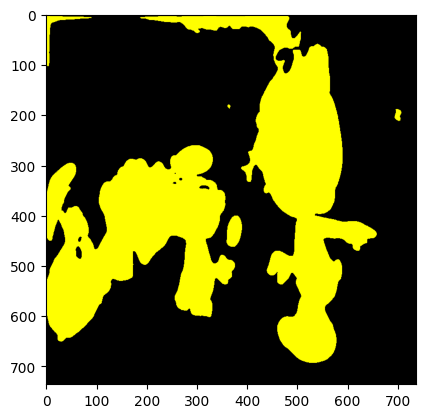

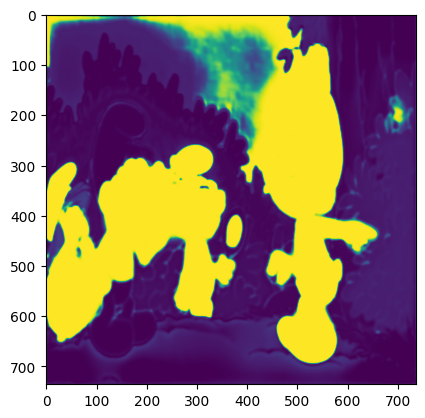

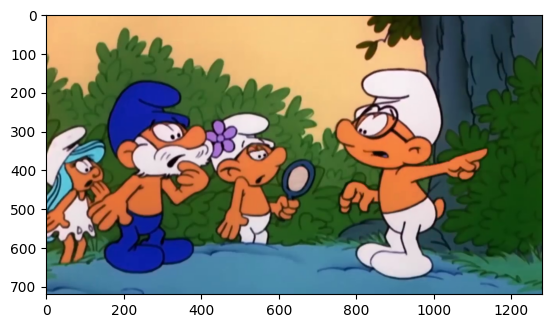

In [72]:
plt.figure()
plt.imshow(rgb_bin)

plt.figure()
plt.imshow(segment[0,0,:,:].detach().numpy())

plt.figure()
plt.imshow(frame)

print(segment[0,:,400,75])

# Conclusions

Taking the initial decision of applying image segmentation only was a mistake as I was using the full images for this purpose and the model was having difficulties to converge. Even with several parameter tunning, data augmentation it was not possible to make the model converge. The result of the non converging model was the one showed in the previous section or the one that could be seen in the tensorboard dashboard while training.

On the last moment, I realized that I could've used the bboxes for object detection and then apply the segmentation over the different ROIs of the image. However, I tried to develop this approach by etending the smurfs data-set where I was also transforming the bboxes and then cropping the segmentation target mask and the input image according to the bbboxes coordinates. 

If such solution would've been thought from the beginning probably I would have been presenting different results for this problem.